In [ ]:
!pip install scikit-learn
!pip install metrics

In [2]:
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    confusion_matrix,
    accuracy_score,
)
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import numpy as np
# from metrics import beta_cv

# Load processed data
# with open("processed_images_data_3.pickle", "rb") as f:
with open("pca_processed_images_with_labels.pickle", "rb") as f:
    images_data = pickle.load(f)

# with open("processed_hogs_data_3.pickle", "rb") as f:
with open("pca_processed_hogs_with_labels.pickle", "rb") as f:
    hogs_data = pickle.load(f)

In [12]:
images_features = images_data[:, :-1]
hogs_features = hogs_data[:, :-1]
images_labels = images_data[:, -1]
hogs_labels = hogs_data[:, -1]

features = np.hstack((images_features, hogs_features))  # Replace with hogs_features if needed
features = PCA(n_components=100).fit_transform(features)
labels = hogs_labels  # Replace with hogs_labels if needed

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3)

# Create and fit KMeans model
kmeans = KMeans(n_clusters=4, max_iter=1000)  # random_state for reproducibility
# kmeans.n_iter_ = 500  # Set number of iterations
print(len(train_features))
kmeans.fit(train_features)

In [ ]:
cluster_labels = []
for i in range(4):
  inds = np.argwhere(kmeans.labels_ == i)[:,0]
  label_mode, _ = mode(train_labels[inds])
  cluster_labels.append(label_mode)
cluster_labels = np.array(cluster_labels)
cluster_labels

In [ ]:
cluster_labels = []
for i in range(4):
  cluster_center = kmeans.cluster_centers_[i,:]
  dists = []
  for j in range(4):
    inds = np.argwhere(kmeans.labels_ == j)[:,0]
    dists.append(np.linalg.norm(train_features[inds] - cluster_center) / len(inds))
  print(dists)
  cluster_labels.append(np.argmin(dists))
cluster_labels = np.array(cluster_labels)
cluster_labels

In [31]:
from clustering_eval import beta_cv
# Predict cluster labels
predicted_clusters = kmeans.predict(test_features)
predicted_labels = cluster_labels[predicted_clusters]

# Evaluate clustering performance
silhouette_avg = silhouette_score(test_features, predicted_labels)
calinski_harabasz = calinski_harabasz_score(test_features, predicted_labels)

print("Silhouette Coefficient:", silhouette_avg)
print("Calinski-Harabasz Index:", calinski_harabasz)


cm = confusion_matrix(test_labels, predicted_labels)
accuracy = accuracy_score(test_labels, predicted_labels)
beta_cv_score = beta_cv(test_features, predicted_labels)

print("Beta CV Score:", beta_cv_score)
print("Confusion Matrix:\n", cm)
# Analyze the confusion matrix:
# - High diagonal values == better
# - Off-diagonal values == misclassifications.

print("Accuracy:", accuracy)  # higher == better

# save model
with open("kmeans_model_images.pickle", "wb") as f:
    pickle.dump(kmeans, f)

: 

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Select a random subset of data
subset_size = 200  # Adjust the subset size as needed
random_indices = random.sample(range(len(features)), subset_size)
subset_features = features[random_indices]

# Create and fit KMeans model on the subset
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_features)

# Predict cluster labels for the subset
predicted_labels = predicted_labels[kmeans.predict(subset_features)]

# Reduce dimensionality using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(subset_features)

# Plot clusters
colors = ["blue", "green", "red", "orange"]
colors = np.array(colors)
for i in range(4):
    cluster_data = reduced_features[predicted_labels == i]
    cluster_labels = labels[random_indices][predicted_labels == i]

    # reshape
    cluster_data = np.hstack((cluster_data, np.zeros((cluster_data.shape[0], 1))))
    cluster_data[:, 2] = np.array(cluster_labels)

    plt.scatter(
        cluster_data[:, 0],
        cluster_data[:, 1],
        c=colors[cluster_data[:, 2].astype(int)],
        label=f"Cluster {i}",
    )

plt.title("KMeans (Random Subset with PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## Results

### Images
Silhouette Coefficient: 0.07437938050979319

Calinski-Harabasz Index: 349.41544056745397

Beta-CV value: 366.9067013578043

Confusion Matrix:

 [[258 417 238 249]

 [378 362 207 245]

 [207  99  29 178]

 [383 200  78 324]]

Accuracy: 0.2525960539979232

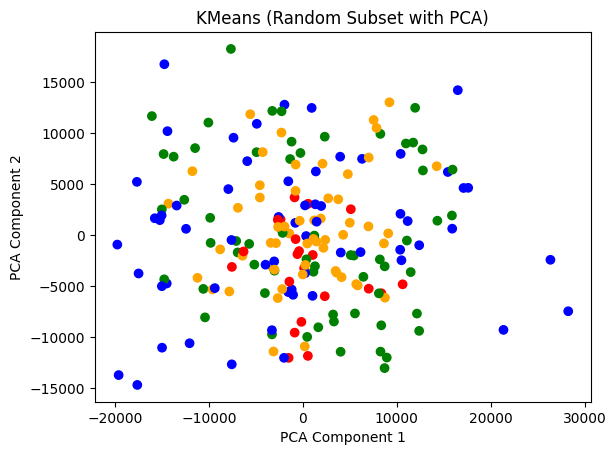

### HOGS (Histogram of Oriented Gradients)
Silhouette Coefficient: 0.08140483623935373

Calinski-Harabasz Index: 338.03792500609984


Confusion Matrix:

 [[353 185 337 287]

 [603 239 229 121]

 [261 110  93  49]

 [458 208 215 104]]

Accuracy: 0.20482866043613707

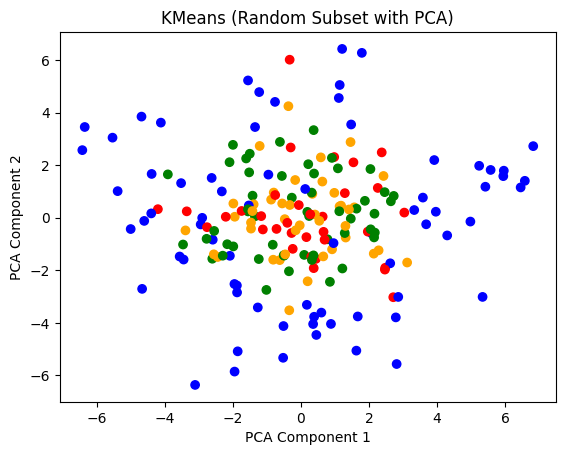

Based on pretty much every metric used to evaluate the clustering we've done, this is a very bad clustering. The accuracy is around ~0.25, which is about the same as guessing randomly, given that there were only four clusters. The silhouette coefficient is near 0 for the clustering, which indicates that there are many overlapping clusters. The Beta CV score indicates that the average intra-cluster distance is much greater than the distance to the nearest cluster center (over 300x), which gives more evidence that the clusters are not spread out and are generally overlapping.